<a href="https://colab.research.google.com/github/nagarajan1/STTP-SLOT-1/blob/master/sentimentAnalysisLstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.layers.core import Activation, Dense, Dropout, SpatialDropout1D
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
import collections
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
MAX_FEATURES = 2000
MAX_SENTENCE_LENGTH = 40

EMBEDDING_SIZE = 128
HIDDEN_LAYER_SIZE = 64
BATCH_SIZE = 32
NUM_EPOCHS = 10

In [5]:
# Read training data and generate vocabulary
maxlen = 0
word_freqs = collections.Counter()
num_recs = 0
fftrain = open("drive/My Drive/training.txt", 'rb')
ftrain=fftrain.readlines()
import nltk
nltk.download('punkt')
for line in ftrain:
    #print("verification",line)
    label, sentence = str(line,"utf-8").strip().split("\t")
    sentence=sentence.encode("ascii", "ignore")
    words = nltk.word_tokenize(sentence.decode("ascii", "ignore").lower())
    if len(words) > maxlen:
        maxlen = len(words)
    for word in words:
        word_freqs[word] += 1
    num_recs += 1
fftrain.close()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [6]:
## Get some information about our corpus
#print maxlen            # 42
#print len(word_freqs)   # 2313

# 1 is UNK, 0 is PAD
# We take MAX_FEATURES-1 featurs to accound for PAD
vocab_size = min(MAX_FEATURES, len(word_freqs)) + 2
word2index = {x[0]: i+2 for i, x in 
                enumerate(word_freqs.most_common(MAX_FEATURES))}
word2index["PAD"] = 0
word2index["UNK"] = 1
index2word = {v:k for k, v in word2index.items()}

In [7]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
# convert sentences to sequences
X = np.empty((num_recs, ), dtype=list)
y = np.zeros((num_recs, ))
i = 0
fftrain = open("drive/My Drive/training.txt", 'rb')
ftrain=fftrain.readlines()
for line in ftrain:
    print("verification",line)
    label, sentence = str(line,"utf-8").strip().split("\t")
    sentence=sentence.encode("ascii", "ignore")
    words = nltk.word_tokenize(sentence.decode("ascii", "ignore").lower())
    seqs = []
    for word in words:
        #print(word2index)
        if word in word2index:
            seqs.append(word2index[word])
        else:
            seqs.append(word2index["UNK"])
    X[i] = seqs
    y[i] = int(label)
    i += 1
fftrain.close()

Streaming output truncated to the last 5000 lines.
verification b'1\tAlso: " Sexy Harry Potter.\n'
verification b'1\tI want to be a part of this community because I love Harry Potter and want to discuss it and theories about book 7 with other people that love Harry Potter.\n'
verification b'1\tAlso: " Sexy Harry Potter.\n'
verification b"1\tHarry Potter and the Sorcerer's Stone is great but I had forgotten what a low reading level it is. > _ <..\n"
verification b'1\tI enjoy discussing Harry Potter, and I know there is still a lot for me to learn about it.\n'
verification b'1\tMe, I like the Harry Potter movies but the books have no real appeal for me.\n'
verification b"1\tBecause I like Harry Potter and I in Eragon's case, I like dragons...\n"
verification b"1\tI love Harry Potter and if there's someone like him, I wanna date him... -- Jamaica, Queens..\n"
verification b'1\tThe Harry Potter Earrings Girl was awesome...\n'
verification b'1\tWhich just goes to show how much I love Harry 

In [11]:
# Pad the sequences (left padded with zeros)
X = sequence.pad_sequences(X, maxlen=MAX_SENTENCE_LENGTH)

In [12]:
# Split input into training and test
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, 
                                                random_state=42)
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

(5668, 40) (1418, 40) (5668,) (1418,)


In [13]:
# Build model
model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_SIZE, 
                    input_length=MAX_SENTENCE_LENGTH))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(HIDDEN_LAYER_SIZE, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1))
model.add(Activation("sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam", 
              metrics=["accuracy"])

history = model.fit(Xtrain, ytrain, batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS,
                    validation_data=(Xtest, ytest))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 5668 samples, validate on 1418 samples
Epoch 1/10
5668/5668 [==============================] - 8s 1ms/step - loss: 0.2343 - accuracy: 0.8959 - val_loss: 0.0591 - val_accuracy: 0.9781
Epoch 2/10
5668/5668 [==============================] - 7s 1ms/step - loss: 0.0276 - accuracy: 0.9921 - val_loss: 0.0449 - val_accuracy: 0.9831
Epoch 3/10
5668/5668 [==============================] - 7s 1ms/step - loss: 0.0085 - accuracy: 0.9981 - val_loss: 0.0421 - val_accuracy: 0.9880
Epoch 4/10
5668/5668 [==============================] - 7s 1ms/step - loss: 0.0063 - accuracy: 0.9982 - val_loss: 0.0463 - val_accuracy: 0.9880
Epoch 5/10
5668/5668 [==============================] - 7s 1ms/step - loss: 0.0031 - accuracy: 0.9991 - val_loss: 0.0480 - val_accuracy: 0.9873
Epoch 6/10
5668/5668 [==============================] - 7s 1ms/step - loss: 0.0027 - accuracy: 0.9993 - val_loss: 0.0538 - val_accuracy: 0.9838
Epoch 7/10
5668/5668 [==============================] - 7s 1ms/step - loss: 0.0021 - acc

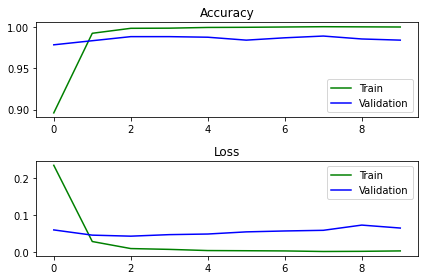

In [14]:
# plot loss and accuracy
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["accuracy"], color="g", label="Train")
plt.plot(history.history["val_accuracy"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="Train")
plt.plot(history.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

In [15]:
# evaluate
score, acc = model.evaluate(Xtest, ytest, batch_size=BATCH_SIZE)
print("Test score: %.3f, accuracy: %.3f" % (score, acc))

for i in range(5):
    idx = np.random.randint(len(Xtest))
    xtest = Xtest[idx].reshape(1,40)
    ylabel = ytest[idx]
    ypred = model.predict(xtest)[0][0]
    sent = " ".join([index2word[x] for x in xtest[0].tolist() if x != 0])
    print("%.0f\t%d\t%s" % (ypred, ylabel, sent))

1418/1418 [==============================] - 0s 286us/step
Test score: 0.064, accuracy: 0.984
1	1	he 's like , 'yeah i got acne and i love brokeback mountain '..
1	1	i liked the first `` mission impossible .
1	1	mission impossible 3 was excellent .
1	1	i like mission impossible movies because you never know who 's on the right side .
0	0	so brokeback mountain was really depressing .
